# Introduction

In this tutorial, we will explain the basics of extending Data Detective to new data types, new validator methods, new validators, and new transforms. We will build up to performing anomaly detection on the MNIST dataset using PCA anomaly scoring.

Prerequisites include all of the information in the Data Detective Basics tutorial.

Let's get started!

In [1]:
!pip install --upgrade pyod
!pip install --upgrade torchvision


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyod
import torch
import torchvision.transforms as transforms

from typing import Dict, Union, Set, Type

from constants import FloatTensor
from src.aggregation.rankings import ResultAggregator, RankingAggregationMethod
from src.data_detective_engine import DataDetectiveEngine
from src.enums.enums import DataType, ValidatorMethodParameter
from src.validators.data_validator import DataValidator


# Dataset Construction

In [3]:
from src.datasets.tutorial_dataset import TutorialDataset


dataset = TutorialDataset(
    root='./data/MNIST',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

# Creating a Validator Method

## The Structure of Validator Methods

Each validator method is a static class that has 4 static, functional methods:
1. The `datatype` method, which returns a set of datatypes that are supported by the validator method. 
<!---The set is considered an "OR" relation (that is, if any of of the datatypes in the set are present in the dataset, the validator method will be applied). --->
2. The `param_keys` method, which returns a set containinng the data splits that the method applies to. 
3. The `validate` method, which returns some type of actionable result. 
4. The `get_method_kwargs` method, which takes in the data object and validator kwargs and sets up the calls to `validate`. 

Let's go through a simple validator method and examine all of these components. The example validator method that we will be examining determines the principle components of a multidimensional column over a dataset and uses reconstruction error over the fitted principle components to provide an anomaly score. 

## Example: PCA Anomaly Validator Method

The first step in writing a new validator method is creating a good test for the validator method using synthetic data. Tests are a crucial part of the data detective validator method construction process for three reasons: 
1. They are helpful early on in the design process for considering and enforcing sensible top-down interface decisions.
2. They are a useful piece of documentation to both yourself as you write the method and to an end user in understanding how to use your method.
3. They verify correctness of your implementation. 

For our example, we will be constructing a 10-dimensional synthetic normal dataset with 99% of samples drawn from N(μ=0, σ=1) and 1% of samples drawn from N(μ=10, σ=1). In order to examine correctness, we will look at the AUCRoC scores between the true anomaly labels and the incorrect anomaly labels. The test that we will be using is shown below. [TODO: write test]

### 1. `datatype()` method

We would like our PCA method to take in only multidimensional data, so let's specify that in the `datatype()` method. We specify this by returning a set of `DataType` objects. If we had wanted to start extending support to new datatypes, we would at this point extend the `DataType` enumeration and specify the new data type in the `datatype` method. 

In [4]:
def datatype() -> Set[DataType]:
    """
    @return: the datatype the validators method operates on.
    """
    return { DataType.MULTIDIMENSIONAL }

### 2. `param_keys()` method

PCA Anomaly validation is an unsupervised method, so it needs to take in the entire dataset to fit/evaluate the model on.

In [5]:
def param_keys() -> Set[ValidatorMethodParameter]:
    """
    Lists the data splits that the validators operates on.
    
    @return: a set of data splits for the .validate() method.
    """
    return { ValidatorMethodParameter.ENTIRE_SET }

### 3. `validate()` method

Our `validate()` method will map us from some representation of the data to a single result. For the PCA `validate()` method, let's choose to take in the entire n x d data matrix for a given column of data and an option indicating the number of components to keep for computation of outlier scores. In the method body, we will fit an existing PCA anomaly detection method from `pyod` and use that model to give us a set of anomaly scores based on reconstruction loss.


In [6]:
def validate(
    data_matrix: Type[np.array] = None, # n x d data matrix for a givenn column
    n_components=None,
) -> object:
    """
    Runs PCA anomaly detection.

    @return: a list of n scores, one per sample. 
    """
    model = pyod.models.pca.PCA(n_components=n_components)
    model.fit(data_matrix)

    anomaly_scores = model.decision_function(data_matrix)

    # mapping output results to sample ids.
    return dict(enumerate(anomaly_scores))

### 4. `get_method_kwargs()` method

In the `get_method_kwargs()` method, we will be taking the set of options passed in the validation schema as well as the data object and setting up the calls to the `validate()` method. This method should return a dictionary where each value contains the kwargs for a `validate()` call and each key reflects where the `validate()` call will store its results in the final method results dictionary. 

Every `get_method_kwargs()` method accepts two things: the validation schema and the data object. For our PCA anomaly example, we will want to perform one call for each entry in the data object, giving us a score for each column of each sample. 

<!--Every `get_method_kwargs()` method accepts two things: the validation schema and the (filtered) data object. The data object is preliminarily filtered in two ways: 
1. The `include` option in the validation schema accepts a list of regular expressions under each 
2. The `datatype()` method results in the data object being filtered to only include columns in that data object.-->


First, we will include a helper method to get the data matrix from a dataset:

In [7]:
def _get_data_matrix_dict(dataset: torch.utils.data.Dataset = None) -> Dict[str, np.array]:
    """
    Takes a dataset and returns a dictionary mapping from each column in the dataset to an n x d 
    numpy array, where n is the number of entries in the dataset and d is the column's dimension
    in the dataset. 
        
    @return: an n x d numpy array, where n is the number of entries in the dataset and d is the 
    column's dimension in the dataset. 
    """
    matrix_dict = {
        column: [] for column in dataset.datatypes().keys()
    }

    for idx in range(dataset.__len__()):
        sample = dataset[idx]
        for column, column_data in sample.items():
            matrix_dict[column].append(column_data)

    for column in dataset.datatypes().keys():
        matrix_dict[column] = np.vstack(matrix_dict[column])
            
    return matrix_dict

Now, let's use the above method to write our `get_method_kwargs()` function, which needs to retrieve our `data_matrix` and `n_components` parameters. 

In [8]:
def get_method_kwargs(data_object: Dict[str, torch.utils.data.Dataset], validator_kwargs: Dict = None) -> Dict:
    """
    Gets the arguments for each run of the validator_method, and what to store the results under.

    @param data_object: the datasets object containing the datasets (train, test, entire, etc.)
    @param validator_kwargs: the kwargs from the validation schema.
    @return: a dict mapping from the key the result from calling .validate() on the kwargs values.
    """
    entire_dataset: torch.utils.data.Dataset = data_object["entire_set"]
    matrix_dict = _get_data_matrix_dict(entire_dataset)
        
    kwargs_dict = {
        f"{column}_results": {
            "data_matrix": column_data,
            "n_components": validator_kwargs.get("n_components")
                            # ^will default to None if n_components is not provided
        } for column, column_data in matrix_dict.items()
    }

    return kwargs_dict

Great! Let's wrap all of the methods we have written in a single class.

In [9]:
import typing
from typing import Set, Dict, Type

import numpy as np
import pyod.models.pca
from torch.utils.data import Dataset

from src.enums.enums import DataType, ValidatorMethodParameter
from src.validator_methods.data_validator_method import DataValidatorMethod

class MyPCAAnomalyValidatorMethod(DataValidatorMethod):
    """
    A method for determining anomalies on multidimensional data. Operates on continuous datasets.
    """
    @staticmethod
    def name() -> str: 
        return "my_pca_validator_method"

    @staticmethod
    def datatype() -> Set[DataType]:
        return datatype()


    @staticmethod
    def param_keys() -> Set[ValidatorMethodParameter]:
        """
        @return: a set of data splits for the data object to include.
        """
        return param_keys()

    @staticmethod
    def get_method_kwargs(data_object: typing.Dict[str, Dataset], validator_kwargs: Dict = None) -> Dict:
        """
        Gets the arguments for each run of the validator_method, and what to store the results under.

        @param data_object: the datasets object containing the datasets (train, test, entire, etc.)
        @param validator_kwargs: the kwargs from the validation schema.
        @return: a dict mapping from the key the result from calling .validate() on the kwargs values.
        """
        return get_method_kwargs(data_object, validator_kwargs)

    @staticmethod
    def validate(
        data_matrix: Type[np.array] = None, # n x d data matrix for a givenn column
        n_components=None,
    ) -> object:
        """
        Runs PCA anomaly detection.

        @return: a list of n scores, one per sample. 
        """
        return validate(data_matrix, n_components)

# Creating a Validator

Validators are simply sets of validator methods. Creating a new one is relatively straightforward. They consist of the set of validator methods that they include as well as a `default` attribute indicating whether the validator should be included in all validation schemas. Let's create a non-default validator for our PCA anomaly method.

In [10]:
class MyUnsupervisedAnomalyDataValidator(DataValidator):
    """
    A dataset has many features/columns, and each column has many ValidatorMethods that apply to it, depending on the
    datatype. A DataValidator is a collection of ValidatorMethods for a unique purpose.
    """
    @staticmethod
    def name() -> str: 
        return "my_unsupervised_anomaly_data_validator"
    
    @staticmethod
    def is_default():
        return False

    @staticmethod
    def validator_methods() -> Set[Type[DataValidatorMethod]]:
        return {
            MyPCAAnomalyValidatorMethod
        }

# Creating a Transform

There are two steps to creating a new transform: 

1. Creating a higher order transformation function
2. Registering the new transform in the transform library. 

Let's look at an example of a simple transform that maps images to their ResNet50 embeddings.

In [11]:
from src.transforms.embedding_transformer import Transform


def get_resnet50(**kwargs):
    import torchvision.models

    resnet = torchvision.models.resnet50(
        weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2, **kwargs
    )
    modules = list(resnet.children())[:-1]
    backbone = torch.nn.Sequential(torch.nn.Upsample((224, 224)), *modules)

    def full_impl(x):
        if len(x.shape) == 2:
            # add channel dimension
            x = torch.unsqueeze(x, 0)
        if len(x.shape) == 3:
            # need a 4th dimension
            x = torch.unsqueeze(x, 0)
        if x.shape[1] == 1:
            # if 1ch need from 1ch to 3ch RGB
            x = x.expand(x.shape[0], 3, *x.shape[2:])
        x = backbone(x)
        x = x.squeeze()
        x = x.reshape((-1, 2048))
        x = x.detach().numpy()
        return x

    return full_impl

my_resnet50_transform = Transform(
        transform_class=get_resnet50,
        new_column_name_fn=lambda name: f"resnet50_backbone_{name}",
        new_column_datatype=DataType.MULTIDIMENSIONAL
    )

There are a few patterns worth noting in the above implementation. The `get_{transform}` higher order function always takes in kwargs that are passed through from the `options` parameter of the input transforms. 

The most important is the use of an inner helper function (in this case, `full_impl`) that is returned. Returning an inner function allows for one-time initialization of the backbone and of the parsing of options in kwargs. 

Now that we have our new validator and transform, let's register them with the Data Detective Engine so we can use them in our investigation and try them out!

In [12]:
# todo: this is what we want the implementation of the data_detective_engine to look like. 
# we need to parse this into two tutorials: one for contributions to the existing codebase, and one for modular extensions.

data_detective_engine = DataDetectiveEngine()

data_detective_engine.register_validator(MyUnsupervisedAnomalyDataValidator)
data_detective_engine.register_transform(my_resnet50_transform, "my_resnet50")

validation_schema = {
    "default_inclusion": False,
    "validators": {
        "my_unsupervised_anomaly_data_validator": {},
    },
    "transforms": {
        "IMAGE": [{
            "name": "my_resnet50",
            "in_place": "False",
            "options": {},
        }],
    }
}

data_object = {
    "entire_set": dataset
}

# Running the Data Detective Engine

Now that the full validation schema and data object are prepared, we are ready to run the Data Detective Engine.

In [13]:
results = data_detective_engine.validate_from_schema(validation_schema, data_object)

running validator class my_unsupervised_anomaly_data_validator...
thread 11227443200 entered to handle validator method my_pca_validator_method
thread 11227443200:    running my_pca_validator_method...
thread 11227443200: finished


In [14]:
results

{'my_unsupervised_anomaly_data_validator': {'my_pca_validator_method': {'normal_vector_results': {0: 3.835127495376063,
    1: 9.647454029653417,
    2: 3.344730744205417,
    3: 8.991164368989061,
    4: 5.873138539498937,
    5: 2.9717353786280185,
    6: 5.856723219151553,
    7: 7.101826337578437,
    8: 6.083828780158457,
    9: 5.158075318905106,
    10: 6.445064801613743,
    11: 4.182083799048574,
    12: 4.550361861869955,
    13: 6.614810025321459,
    14: 3.4919078885847368,
    15: 10.81379189175019,
    16: 3.241834891843979,
    17: 4.520406440109203,
    18: 6.001637040535556,
    19: 6.661974011053754,
    20: 5.127876554622266,
    21: 3.18729975132028,
    22: 6.071372750064923,
    23: 7.703982159145001,
    24: 5.413674372949272,
    25: 3.127995287436004,
    26: 6.372571563541092,
    27: 8.133995950658383,
    28: 3.9698711433127354,
    29: 7.329935972136699,
    30: 3.616349743225573,
    31: 5.190025887627105,
    32: 9.24038875395927,
    33: 7.31479164935322

Great! Let's start to look at and analyze the results we've collected.

# Interpreting Results using the Built-In Rank Aggregator

In [15]:
aggregator = ResultAggregator(results_object=results)
input_df = aggregator.aggregate_results_modally("my_unsupervised_anomaly_data_validator", [RankingAggregationMethod.LOWEST_RANK, RankingAggregationMethod.HIGHEST_RANK, RankingAggregationMethod.ROUND_ROBIN], given_data_modality="resnet50_backbone_mnist_image")
input_df

,resnet50_backbone_mnist_image_results_my_pca_validator_method_rank,lowest_rank_agg_rank,highest_rank_agg_rank,round_robin_agg_rank,resnet50_backbone_mnist_image_results_my_pca_validator_method_score
0,119,119,119,119,1.042890e+16
1,190,190,190,190,9.822640e+15
2,261,261,261,261,9.454395e+15
3,142,142,142,142,1.022350e+16
4,405,405,405,405,8.842157e+15
...,...,...,...,...,...
495,24,24,24,24,1.193300e+16
496,400,400,400,400,8.859369e+15
497,344,344,344,344,9.103531e+15
498,429,429,429,429,8.712331e+15


5
tensor(0.) tensor(1.)


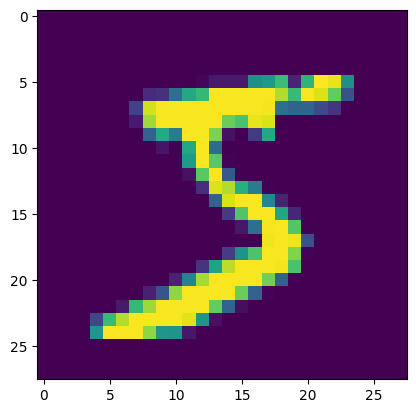

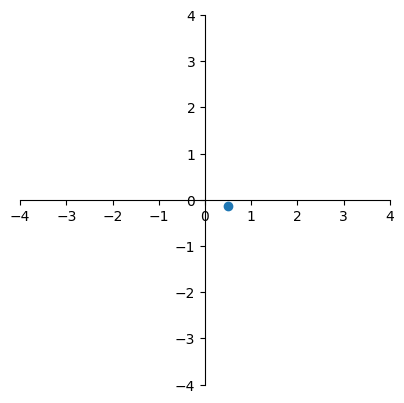

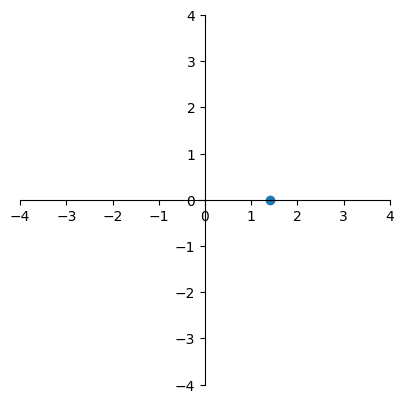

In [16]:
dataset.show_datapoint(0)